### Link:https://www.kaggle.com/c/bengaliai-cv19 

In [2]:
import zipfile
with zipfile.ZipFile('bengaliai-cv19.zip', 'r') as zip_ref:
    zip_ref.extractall('input/')

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import cv2
import os

In [2]:
for dirname, _, filenames in os.walk('input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input/class_map.csv
input/sample_submission.csv
input/test.csv
input/test_image_data_0.parquet
input/test_image_data_1.parquet
input/test_image_data_2.parquet
input/test_image_data_3.parquet
input/train.csv
input/train_image_data_0.parquet
input/train_image_data_1.parquet
input/train_image_data_2.parquet
input/train_image_data_3.parquet


### Read all the CSV files

In [3]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
df_class_map = pd.read_csv('input/class_map.csv')
df_sample_submission = pd.read_csv('input/sample_submission.csv')

### Read all the image files

In [4]:
df_train_img_0 = pd.read_parquet('input/train_image_data_0.parquet')
df_train_img_1 = pd.read_parquet('input/train_image_data_1.parquet')
df_train_img_2 = pd.read_parquet('input/train_image_data_2.parquet')
df_train_img_3 = pd.read_parquet('input/train_image_data_3.parquet')
df_test_img_0 = pd.read_parquet('input/test_image_data_0.parquet')
df_test_img_1 = pd.read_parquet('input/test_image_data_1.parquet')
df_test_img_2 = pd.read_parquet('input/test_image_data_2.parquet')
df_test_img_3 = pd.read_parquet('input/test_image_data_3.parquet')

In [5]:
print('shape of df_train:', df_train.shape)
print('shape of df_test:', df_test.shape)
print('shape of df_class_map:', df_class_map.shape)
print('shape of df_submission:', df_sample_submission.shape)

print('shape of df_train_img_0:', df_train_img_0.shape)
print('shape of df_train_img_1:', df_train_img_1.shape)
print('shape of df_train_img_2:', df_train_img_2.shape)
print('shape of df_train_img_3:', df_train_img_3.shape)
print('shape of df_test_img_0:', df_test_img_0.shape)
print('shape of df_test_img_1:', df_test_img_1.shape)
print('shape of df_test_img_2:', df_test_img_2.shape)
print('shape of df_test_img_3:', df_test_img_3.shape)

shape of df_train: (200840, 5)
shape of df_test: (36, 3)
shape of df_class_map: (186, 3)
shape of df_submission: (36, 2)
shape of df_train_img_0: (50210, 32333)
shape of df_train_img_1: (50210, 32333)
shape of df_train_img_2: (50210, 32333)
shape of df_train_img_3: (50210, 32333)
shape of df_test_img_0: (3, 32333)
shape of df_test_img_1: (3, 32333)
shape of df_test_img_2: (3, 32333)
shape of df_test_img_3: (3, 32333)


In [6]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
            resized[df.index[i]] = image.reshape(-1)
    else:
        for i in range(df.shape[0]):
            image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
            resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

In [8]:
df_train.head()

image_id  grapheme_root  vowel_diacritic  consonant_diacritic grapheme
0  Train_0             15                9                    5   ক্ট্রো
1  Train_1            159                0                    0        হ
2  Train_2             22                3                    5     খ্রী
3  Train_3             53                2                    2     র্টি
4  Train_4             71                9                    5     থ্রো

In [10]:
df_train = df_train.drop(['grapheme'], axis=1, inplace=False)

In [11]:
df_train.head()

image_id  grapheme_root  vowel_diacritic  consonant_diacritic
0  Train_0             15                9                    5
1  Train_1            159                0                    0
2  Train_2             22                3                    5
3  Train_3             53                2                    2
4  Train_4             71                9                    5

In [12]:
df_train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = df_train[       ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [16]:
def identity_block(X, f, filters, stage, block):
    """
    ResNet Identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, 
    defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, 
    depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), 
        padding='valid',    name=conv_name_base + '2a', 
        kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, 
    name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), 
        strides=(1, 1), padding='same', 
        name=conv_name_base + '2b',
        kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), 
    strides=(1, 1), padding='valid', 
    name=conv_name_base + '2c', 
    kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [18]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in
     the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, 
    depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), 
        strides=(s, s), padding='valid', 
        name=conv_name_base + '2a', 
        kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), 
        strides=(1, 1), padding='same', 
        name=conv_name_base + '2b', 
        kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, 
        kernel_size=(1, 1), 
        strides=(1, 1), padding='valid', 
        name=conv_name_base + '2c', 
        kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, 
        kernel_size=(1, 1), strides=(s, s), 
        padding='valid', 
        name=conv_name_base + '1', 
        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [26]:
from tqdm.auto import tqdm
from glob import glob
import time, gc
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D,BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.utils import layer_utils
# from tensorflow.keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [27]:
def ResNet50(input_shape=(64, 64, 1), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', 
        kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', 
    name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [28]:
model_root = ResNet50(input_shape=(64, 64, 1), classes=168)
model_vowel = ResNet50(input_shape=(64, 64, 1), classes=11)
model_consonant = ResNet50(input_shape=(64, 64, 1), classes=7)

In [29]:
model_root.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vowel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_consonant.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
IMG_SIZE=64
N_CHANNELS=1
batch_size = 32
epochs = 20
model_dict = {
    'grapheme_root': model_root,
    'vowel_diacritic': model_vowel,
    'consonant_diacritic': model_consonant
}

In [33]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

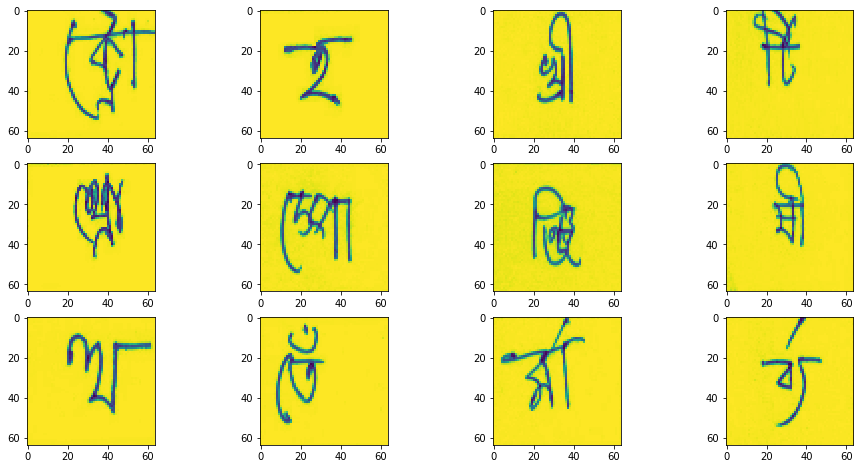

0%|          | 0/200840 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 1 into shape (137,236)

In [34]:
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'input/train_image_data_{i}.parquet'), df_train, on='image_id').drop(['image_id'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 
            'vowel_diacritic', 'consonant_diacritic'], 
            axis=1).iloc[[count]], 
            need_progress_bar=False).values.reshape(64, 64))
            count += 1
    plt.show()
    
    X_train = df_train.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    for target in ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']:
        Y_train = df_train[target]
        Y_train = pd.get_dummies(Y_train).values

        print(f'Training images: {X_train.shape}')
        print(f'Training labels: {Y_train.shape}')
        
        # Divide the data into training and validation set
        x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, 
        test_size=0.10, random_state=666)
        del Y_train
        history = model_dict[target].fit(x_train, 
                                         y_train, 
                                         batch_size=batch_size, 
                                         epochs=epochs, 
                                         callbacks=[learning_rate_reduction],
                                         validation_data=(x_test, y_test))
    
        del x_train
        del x_test
        del y_train
        del y_test    
        histories.append(history)
        gc.collect()
    # Delete to reduce memory usage
    del X_train
    del train_df
    gc.collect()